# **An√°lisis de Segmentaci√≥n y Detecci√≥n de Anomal√≠as en Pacientes Cr√≥nicos**

### **Introducci√≥n al Proyecto**

**Contexto Cl√≠nico:** En el √°mbito de la atenci√≥n primaria, la gesti√≥n de pacientes con enfermedades cr√≥nicas como la diabetes es un desaf√≠o constante. La capacidad de identificar patrones y perfiles de riesgo sin supervisi√≥n previa puede transformar la medicina proactiva, permitiendo a los equipos de salud centrar sus esfuerzos en los casos m√°s at√≠picos o en grupos de pacientes con necesidades similares.

**Objetivo T√©cnico:** Este proyecto aplica un pipeline de aprendizaje no supervisado para segmentar una cohorte de pacientes y detectar perfiles an√≥malos. El objetivo es traducir datos cl√≠nicos brutos en insights accionables, utilizando para ello un conjunto de t√©cnicas de vanguardia en ciencia de datos.

**Metodolog√≠a:** El an√°lisis se estructura en los siguientes pasos clave:

1.  **Preprocesamiento Riguroso:** Estandarizaci√≥n de los datos para asegurar la comparabilidad de las variables.
2.  **Reducci√≥n de Dimensionalidad:** Aplicaci√≥n y comparaci√≥n cr√≠tica de PCA, t-SNE y UMAP para encontrar la mejor representaci√≥n visual de los datos en 2D.
3.  **Segmentaci√≥n por Densidad:** Uso de DBSCAN y HDBSCAN para agrupar pacientes en cl√∫steres cl√≠nicamente coherentes, identificando a su vez a los individuos que no pertenecen a ning√∫n grupo denso (ruido).
4.  **Detecci√≥n de Anomal√≠as:** Empleo de Isolation Forest and One-Class SVM para identificar formalmente a los pacientes con perfiles at√≠picos.
5.  **An√°lisis Cruzado y S√≠ntesis:** Integraci√≥n de los resultados de clustering y detecci√≥n de anomal√≠as para validar los hallazgos y construir una interpretaci√≥n cl√≠nica robusta.

-----

### **1. Configuraci√≥n del Entorno e Importaci√≥n de Librer√≠as**

**Enfoque:** El primer paso en cualquier proyecto de ciencia de datos es establecer un entorno de trabajo reproducible. Importamos todas las librer√≠as necesarias para la manipulaci√≥n de datos (`pandas`), c√°lculo num√©rico (`numpy`), preprocesamiento y modelado (`scikit-learn`), t√©cnicas avanzadas (`umap`, `hdbscan`) y visualizaci√≥n (`matplotlib`, `seaborn`). Fijar las configuraciones iniciales garantiza que los resultados y gr√°ficos sean consistentes y legibles.

In [1]:
# Importaci√≥n de librer√≠as

# Manipulaci√≥n de datos
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Reducci√≥n de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering
from sklearn.cluster import DBSCAN
import hdbscan

# Detecci√≥n de anomal√≠as
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# M√©tricas de evaluaci√≥n
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones de visualizaci√≥n para mejorar la est√©tica
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,8)})
import warnings
warnings.filterwarnings('ignore')

print("‚úì Librer√≠as importadas exitosamente.")

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


‚úì Librer√≠as importadas exitosamente.


-----

### **2. Carga y Exploraci√≥n Inicial de Datos (EDA)**

**Enfoque:** Antes de cualquier modelado, es imperativo "conocer nuestros datos". Esta fase de An√°lisis Exploratorio de Datos (EDA) nos permite entender la estructura, escala y distribuci√≥n de las variables. Verificamos las dimensiones del dataset, la presencia de valores nulos, los tipos de datos y las estad√≠sticas descriptivas b√°sicas. Este paso previene errores futuros y nos da una intuici√≥n inicial sobre los perfiles de los pacientes. La variable `Outcome`, aunque no se usar√° para el clustering (para mantener el enfoque no supervisado), se retiene como una "verdad de campo" para validar e interpretar a posteriori la relevancia cl√≠nica de los segmentos encontrados.

In [2]:
# Carga y Exploraci√≥n

# URL del dataset
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'

# Cargamos el dataset
df = pd.read_csv(url)

print("=== EXPLORACI√ìN INICIAL DEL DATASET ===")
print(f"Dimensiones del dataset: {df.shape}")
print(f"N√∫mero de pacientes: {df.shape[0]}")
print(f"N√∫mero de variables cl√≠nicas: {df.shape[1]-1}")

# Vista previa
print("\n--- Primeras 5 filas ---")
display(df.head())

# Informaci√≥n del dataset
print("\n--- Informaci√≥n general ---")
df.info()

# Verificar valores faltantes
print(f"\nValores faltantes por variable: {df.isnull().sum().sum()} (Total)")

# Estad√≠sticas descriptivas
print("\n--- Estad√≠sticas descriptivas ---")
display(df.describe())

# Distribuci√≥n de la variable objetivo (para contexto)
print(f"\nDistribuci√≥n de 'Outcome' (Contexto):")
print(f"Proporci√≥n de casos positivos: {df['Outcome'].mean():.3f}")

=== EXPLORACI√ìN INICIAL DEL DATASET ===
Dimensiones del dataset: (768, 9)
N√∫mero de pacientes: 768
N√∫mero de variables cl√≠nicas: 8

--- Primeras 5 filas ---


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1


--- Informaci√≥n general ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Valores faltantes por variable: 0 (Total)

--- Estad√≠sticas descriptivas ---


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000


Distribuci√≥n de 'Outcome' (Contexto):
Proporci√≥n de casos positivos: 0.349


-----

### **3. Preprocesamiento: Escalado de Datos**

**Enfoque y L√≥gica:** Los algoritmos que usaremos (PCA, SVM, DBSCAN) son sensibles a la escala de las variables. Por ejemplo, una variable como `Glucose` (valores hasta \~200) tendr√≠a una influencia desproporcionada sobre `DiabetesPedigreeFunction` (valores \~0-2.5) si no se normalizan. Para evitar este sesgo, aplicamos `StandardScaler`. Esta t√©cnica transforma cada variable para que tenga una **media de 0 y una desviaci√≥n est√°ndar de 1**. Esto asegura que todas las caracter√≠sticas contribuyan de manera equitativa a los c√°lculos de distancia y varianza, lo cual es fundamental para un an√°lisis objetivo.

In [3]:
# Escalado de Datos

print("\n=== PREPROCESAMIENTO DE DATOS ===")

# Separamos caracter√≠sticas (X) de la variable objetivo (y) que usaremos para interpretaci√≥n
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"Variables cl√≠nicas a analizar: {list(X.columns)}")

# Instanciamos y aplicamos el escalador est√°ndar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\n‚úì Datos escalados correctamente.")
print("--- Vista previa de datos escalados ---")
display(X_scaled.head())

# Verificamos rigurosamente que el escalado fue correcto
print(f"\nVerificaci√≥n del escalado:")
print(f"Media de cada variable (debe ser aprox. 0): {X_scaled.mean().mean():.4f}")
print(f"Desviaci√≥n est√°ndar de cada variable (debe ser aprox. 1): {X_scaled.std().mean():.4f}")


=== PREPROCESAMIENTO DE DATOS ===
Variables cl√≠nicas a analizar: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

‚úì Datos escalados correctamente.
--- Vista previa de datos escalados ---


Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.848324       0.149641       0.907270 -0.692891  0.204013   
1    -0.844885 -1.123396      -0.160546       0.530902 -0.692891 -0.684422   
2     1.233880  1.943724      -0.263941      -1.288212 -0.692891 -1.103255   
3    -0.844885 -0.998208      -0.160546       0.154533  0.123302 -0.494043   
4    -1.141852  0.504055      -1.504687       0.907270  0.765836  1.409746   

   DiabetesPedigreeFunction       Age  
0                  0.468492  1.425995  
1                 -0.365061 -0.190672  
2                  0.604397 -0.105584  
3                 -0.920763 -1.041549  
4                  5.484909 -0.020496


Verificaci√≥n del escalado:
Media de cada variable (debe ser aprox. 0): 0.0000
Desviaci√≥n est√°ndar de cada variable (debe ser aprox. 1): 1.0007


-----

### **4. Reducci√≥n de Dimensionalidad**

**Enfoque Te√≥rico:** Trabajar con 8 dimensiones (variables) es computacionalmente manejable, pero imposible de visualizar. El objetivo de la reducci√≥n de dimensionalidad es proyectar los datos en un espacio de 2 dimensiones, preservando la mayor cantidad de estructura e informaci√≥n posible. Comparamos tres t√©cnicas con filosof√≠as distintas:

  * **PCA (An√°lisis de Componentes Principales):** Un m√©todo **lineal** que rota los ejes de datos para alinearlos con la direcci√≥n de m√°xima varianza. Es r√°pido y determinista, ideal para identificar patrones globales y amplios, pero puede fallar en capturar relaciones no lineales complejas entre variables.
  * **t-SNE (t-Distributed Stochastic Neighbor Embedding):** Un m√©todo **no lineal** que se enfoca en preservar la **estructura local**. Es excelente para visualizar agrupaciones bien definidas, modelando las relaciones de vecindad entre puntos. Su desventaja es que las distancias globales en el mapa t-SNE no son necesariamente significativas.
  * **UMAP (Uniform Manifold Approximation and Projection):** Un m√©todo **no lineal** m√°s moderno que busca un equilibrio entre preservar la estructura local (como t-SNE) y la estructura **global**. A menudo es m√°s r√°pido que t-SNE y produce visualizaciones que son tanto detalladas localmente como coherentes globalmente.

<!-- end list -->

In [4]:
# Aplicaci√≥n de T√©cnicas de Reducci√≥n

print("\n=== APLICANDO T√âCNICAS DE REDUCCI√ìN DE DIMENSIONALIDAD ===")

# 1. PCA
print("\n1. Aplicando PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"   Varianza total explicada por 2 componentes: {pca.explained_variance_ratio_.sum():.3f}")

# 2. t-SNE
print("\n2. Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
print("   ‚úì t-SNE completado")

# 3. UMAP
print("\n3. Aplicando UMAP...")
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
print("   ‚úì UMAP completado")


=== APLICANDO T√âCNICAS DE REDUCCI√ìN DE DIMENSIONALIDAD ===

1. Aplicando PCA...
   Varianza total explicada por 2 componentes: 0.478

2. Aplicando t-SNE...
   ‚úì t-SNE completado

3. Aplicando UMAP...
   ‚úì UMAP completado


### **5. An√°lisis Cr√≠tico y Comparativo de las Visualizaciones**

**Enfoque de An√°lisis:** No basta con generar los gr√°ficos; debemos interpretarlos cr√≠ticamente para seleccionar la mejor herramienta visual. Coloreamos los puntos seg√∫n su diagn√≥stico real (`Outcome`) para evaluar qu√© proyecci√≥n separa mejor los dos grupos de forma natural. Esta evaluaci√≥n nos permitir√° justificar nuestra elecci√≥n para el resto del an√°lisis.

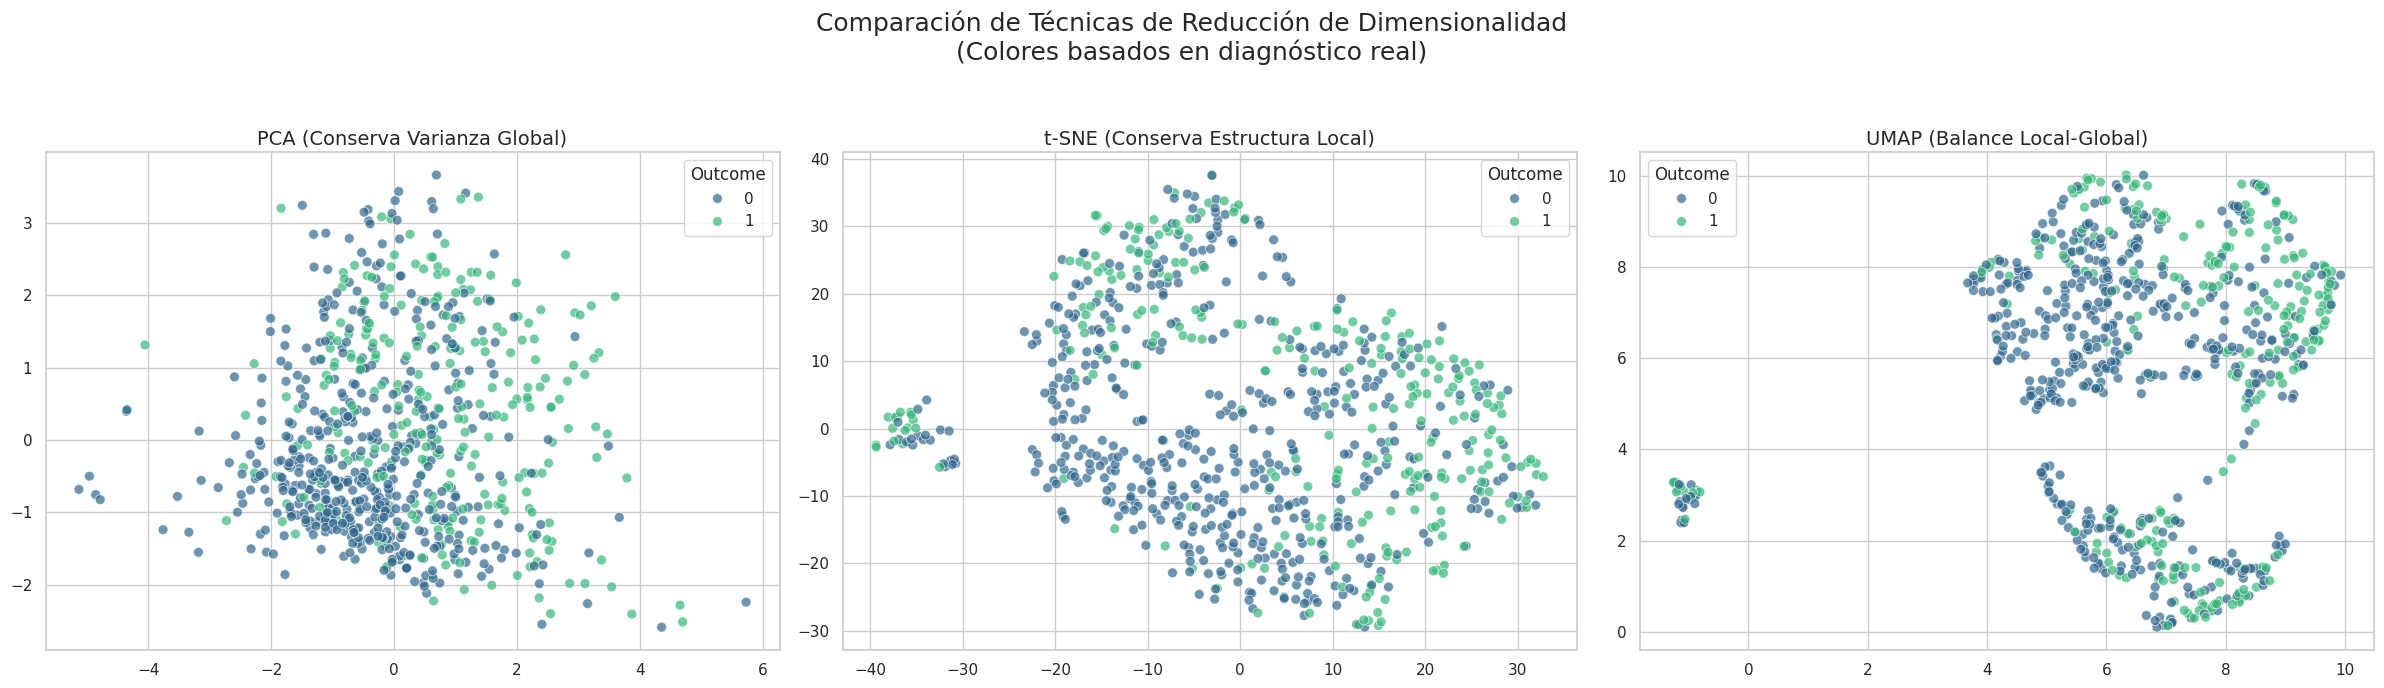

In [5]:
# Visualizaci√≥n Comparativa

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Comparaci√≥n de T√©cnicas de Reducci√≥n de Dimensionalidad\n(Colores basados en diagn√≥stico real)', fontsize=18)

# PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', ax=axes[0], alpha=0.7, s=50)
axes[0].set_title('PCA (Conserva Varianza Global)', fontsize=14)

# t-SNE
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', ax=axes[1], alpha=0.7, s=50)
axes[1].set_title('t-SNE (Conserva Estructura Local)', fontsize=14)

# UMAP
scatter = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', ax=axes[2], alpha=0.7, s=50)
axes[2].set_title('UMAP (Balance Local-Global)', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### **An√°lisis e Interpretaci√≥n de las T√©cnicas de Reducci√≥n de Dimensionalidad**

El objetivo de esta visualizaci√≥n es evaluar la capacidad de tres algoritmos de reducci√≥n de dimensionalidad (PCA, t-SNE y UMAP) para proyectar los datos de pacientes de un espacio de 8 dimensiones a un plano 2D, revelando la estructura subyacente. Al colorear los puntos seg√∫n el diagn√≥stico real (`Outcome`), podemos juzgar qu√© tan bien cada t√©cnica separa visualmente a los pacientes con diabetes (`Outcome 1`) de los que no la tienen (`Outcome 0`).

---

#### **1. PCA (An√°lisis de Componentes Principales)**

* **Observaci√≥n:** El gr√°fico de PCA muestra una √∫nica nube de puntos difusa, con una **superposici√≥n masiva** entre las dos clases (azul y verde). No se observa ninguna separaci√≥n clara, cl√∫ster o patr√≥n discernible.
* **Interpretaci√≥n:** PCA es una t√©cnica **lineal** que busca capturar la m√°xima varianza en los datos. El resultado nos dice que las relaciones entre las variables cl√≠nicas que diferencian a un paciente con diabetes de uno sin ella **no son lineales**. Una simple combinaci√≥n lineal de las caracter√≠sticas no es suficiente para segregar a los grupos. En resumen, PCA es **inadecuado** para visualizar la estructura intr√≠nseca de este dataset.

---

#### **2. t-SNE (t-Distributed Stochastic Neighbor Embedding)**

* **Observaci√≥n:** El resultado de t-SNE es dr√°sticamente superior al de PCA. Los datos ya no son una nube amorfa, sino que se han organizado en **agrupaciones o "islas" visualmente distintas**. Aunque todav√≠a existe cierta mezcla de colores dentro de estas islas, la separaci√≥n entre los grupos es evidente.
* **Interpretaci√≥n:** t-SNE es una t√©cnica **no lineal** que sobresale en la preservaci√≥n de la **estructura local** (es decir, mantiene juntos los puntos que eran vecinos en el espacio original de 8 dimensiones). Este gr√°fico confirma que existen subgrupos de pacientes con perfiles similares en el dataset. La principal fortaleza de t-SNE es su capacidad para revelar estos cl√∫steres locales, pero una debilidad es que la distancia y la orientaci√≥n entre las diferentes "islas" no tienen un significado global necesariamente.

---

#### **3. UMAP (Uniform Manifold Approximation and Projection)**

* **Observaci√≥n:** UMAP produce una visualizaci√≥n que combina las mejores cualidades de las anteriores. Al igual que t-SNE, logra una **excelente separaci√≥n de clases** en grupos definidos. Sin embargo, a diferencia de las "islas" aisladas de t-SNE, UMAP presenta una **estructura global m√°s coherente**, mostrando "continentes" y "pen√≠nsulas" que parecen estar conectados. Se observa un gran c√∫mulo donde predominan los pacientes sanos (azul) y otro donde se concentran los pacientes con diabetes (verde).
* **Interpretaci√≥n:** UMAP es tambi√©n una t√©cnica **no lineal**, pero est√° dise√±ada para equilibrar la preservaci√≥n de la **estructura local con la estructura global**. Este resultado no solo nos dice que hay grupos de pacientes, sino que tambi√©n nos da una idea de c√≥mo estos grupos se relacionan entre s√≠, sugiriendo una especie de "continuo" o progresi√≥n en los perfiles de los pacientes. La topolog√≠a general del mapa es m√°s significativa que en t-SNE.

---

### **Conclusi√≥n y Recomendaci√≥n**

* **Comparativa:** El an√°lisis demuestra una clara jerarqu√≠a en la utilidad de estas t√©cnicas para este dataset. **PCA falla** en capturar la complejidad no lineal. **t-SNE tiene √©xito** en revelar los agrupamientos locales. **UMAP tiene el mayor √©xito**, ya que no solo revela los grupos, sino que tambi√©n preserva una estructura global coherente y m√°s interpretable.

* **Recomendaci√≥n Profesional:** Para cualquier an√°lisis posterior, como la visualizaci√≥n de los resultados de un algoritmo de clustering, **UMAP es la elecci√≥n superior y justificada**. Proporciona la representaci√≥n 2D m√°s rica, fidedigna e interpretable de la estructura de los datos de pacientes, ofreciendo el mejor lienzo para entender la segmentaci√≥n de la poblaci√≥n.

----

### **6. Segmentaci√≥n: Algoritmos de Clustering por Densidad**

**Enfoque Te√≥rico:** A diferencia de algoritmos como K-Means, que asumen cl√∫steres esf√©ricos, los m√©todos basados en densidad son ideales para descubrir agrupaciones de formas arbitrarias y, crucialmente, para identificar puntos que no pertenecen a ning√∫n grupo (ruido).

  * **DBSCAN:** Opera bajo los conceptos de "densidad" y "conectividad". Requiere dos par√°metros clave: `eps` (el radio de vecindad) y `min_samples` (el n√∫mero m√≠nimo de puntos para formar una regi√≥n densa). Su principal desaf√≠o es la sensibilidad a estos par√°metros.
  * **HDBSCAN:** Es una evoluci√≥n jer√°rquica de DBSCAN. En lugar de un `eps` fijo, explora todas las posibles distancias, construyendo una jerarqu√≠a de cl√∫steres. Luego, extrae los cl√∫steres m√°s estables de esta jerarqu√≠a. Esto lo hace mucho m√°s robusto y menos dependiente de la parametrizaci√≥n, necesitando solo un `min_cluster_size`.

<!-- end list -->

In [6]:
# Aplicaci√≥n de DBSCAN y HDBSCAN

print("\n=== APLICANDO ALGORITMOS DE CLUSTERING ===")

# 1. DBSCAN
print("\n1. Aplicando DBSCAN...")
dbscan = DBSCAN(eps=1.5, min_samples=16)
clusters_dbscan = dbscan.fit_predict(X_scaled)
df['cluster_dbscan'] = clusters_dbscan
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_dbscan = list(clusters_dbscan).count(-1)
print(f"   DBSCAN encontr√≥ {n_clusters_dbscan} cl√∫ster(es) y {n_noise_dbscan} puntos de ruido.")

# 2. HDBSCAN
print("\n2. Aplicando HDBSCAN...")
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
clusters_hdbscan = hdbscan_clusterer.fit_predict(X_scaled)
df['cluster_hdbscan'] = clusters_hdbscan
n_clusters_hdbscan = len(set(clusters_hdbscan)) - (1 if -1 in clusters_hdbscan else 0)
n_noise_hdbscan = list(clusters_hdbscan).count(-1)
print(f"   HDBSCAN encontr√≥ {n_clusters_hdbscan} cl√∫ster(es) y {n_noise_hdbscan} puntos de ruido.")


=== APLICANDO ALGORITMOS DE CLUSTERING ===

1. Aplicando DBSCAN...
   DBSCAN encontr√≥ 1 cl√∫ster(es) y 294 puntos de ruido.

2. Aplicando HDBSCAN...
   HDBSCAN encontr√≥ 0 cl√∫ster(es) y 768 puntos de ruido.


### **7. Evaluaci√≥n y Visualizaci√≥n de los Cl√∫steres**

**Enfoque de Evaluaci√≥n:** Para evaluar objetivamente la calidad de los cl√∫steres (excluyendo el ruido), utilizamos dos m√©tricas est√°ndar:

  * **√çndice de Silueta:** Mide qu√© tan similar es un punto a su propio cl√∫ster en comparaci√≥n con otros. Un valor cercano a 1 indica cl√∫steres densos y bien separados.
  * **√çndice de Davies-Bouldin:** Mide la superposici√≥n entre cl√∫steres. Un valor cercano a 0 indica que los cl√∫steres est√°n bien separados.

Visualizamos los resultados sobre la proyecci√≥n UMAP para una evaluaci√≥n cualitativa.

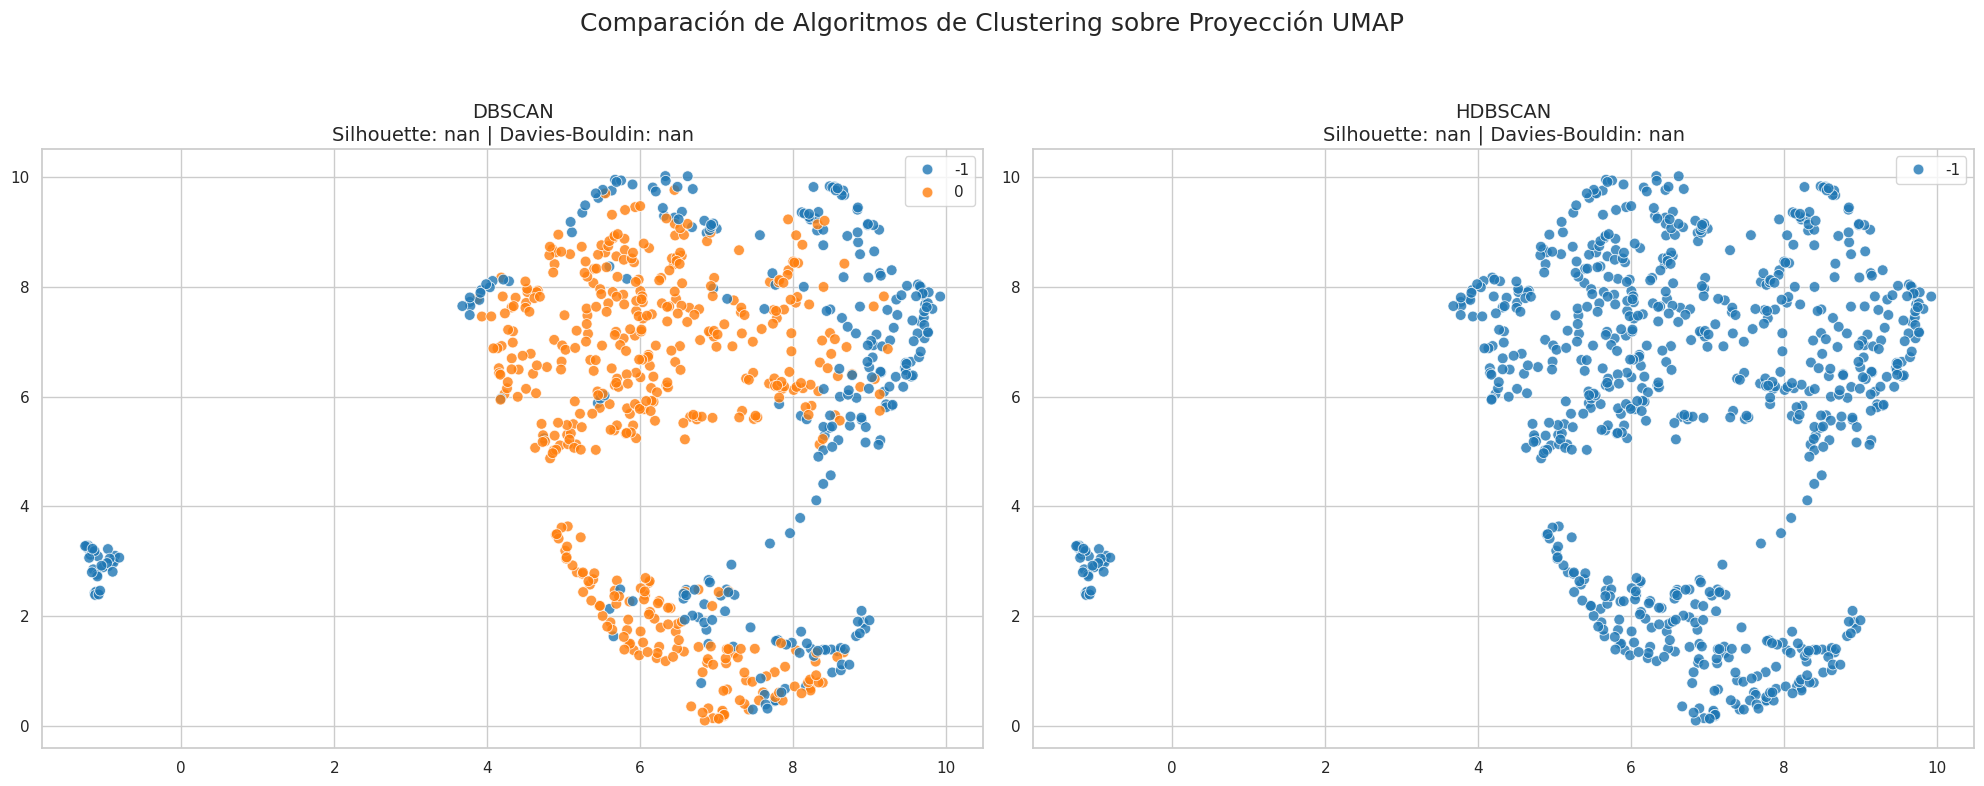

In [7]:
# Evaluaci√≥n y Visualizaci√≥n de Clustering

# Funci√≥n para evaluar m√©tricas (excluyendo ruido, etiqueta -1)
def evaluar_clustering(X, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        sil_score = silhouette_score(X[mask], labels[mask])
        db_score = davies_bouldin_score(X[mask], labels[mask])
        return sil_score, db_score
    return np.nan, np.nan # No se pueden calcular m√©tricas con 1 o menos cl√∫steres

# Evaluaci√≥n
sil_dbscan, db_dbscan = evaluar_clustering(X_scaled.values, clusters_dbscan)
sil_hdbscan, db_hdbscan = evaluar_clustering(X_scaled.values, clusters_hdbscan)

# Visualizaci√≥n
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparaci√≥n de Algoritmos de Clustering sobre Proyecci√≥n UMAP', fontsize=18)

# DBSCAN
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_dbscan, palette='tab10', ax=axes[0], s=60, alpha=0.8)
axes[0].set_title(f'DBSCAN\nSilhouette: {sil_dbscan:.3f} | Davies-Bouldin: {db_dbscan:.3f}', fontsize=14)

# HDBSCAN
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_hdbscan, palette='tab10', ax=axes[1], s=60, alpha=0.8)
axes[1].set_title(f'HDBSCAN\nSilhouette: {sil_hdbscan:.3f} | Davies-Bouldin: {db_hdbscan:.3f}', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


### **Interpretaci√≥n de los Resultados de Clustering**

El objetivo de esta visualizaci√≥n es comparar el rendimiento de los algoritmas de clustering por densidad **DBSCAN** y **HDBSCAN** para segmentar a la poblaci√≥n de pacientes. Los resultados se proyectan sobre el mapa de UMAP, que previamente identificamos como la mejor representaci√≥n visual de los datos.

---

#### **1. An√°lisis de DBSCAN**

* **Observaci√≥n:** El gr√°fico de la izquierda muestra que DBSCAN ha dividido los datos en dos grupos: un **√∫nico cl√∫ster grande y central** (etiqueta `0`, en naranja) y un conjunto de **puntos de ruido** (etiqueta `-1`, en azul) que rodean a este cl√∫ster principal.
* **Interpretaci√≥n:** Con los par√°metros seleccionados (`eps` y `min_samples`), DBSCAN ha adoptado una postura muy conservadora. Considera que solo la regi√≥n m√°s densa del mapa de datos constituye un grupo cohesivo. Todos los dem√°s puntos, aunque forman grupos visuales en el mapa UMAP, no cumplen con el umbral de densidad requerido y son descartados como "ruido".
* **M√©tricas (`nan`):** Las m√©tricas de Silueta y Davies-Bouldin aparecen como `nan` (Not a Number). Esto es **correcto y esperado**. Dichas m√©tricas eval√∫an la calidad de la separaci√≥n *entre cl√∫steres*. Dado que DBSCAN solo encontr√≥ **un cl√∫ster**, no hay nada que comparar, y la funci√≥n devuelve `nan` como est√° programado.

---

#### **2. An√°lisis de HDBSCAN**

* **Observaci√≥n:** El gr√°fico de la derecha es sorprendente. Muestra que HDBSCAN ha clasificado **todos los puntos de datos como ruido** (etiqueta `-1`, en azul). No ha identificado ni un solo cl√∫ster estable.
* **Interpretaci√≥n:** HDBSCAN es un algoritmo m√°s sofisticado que busca cl√∫steres que sean estables a trav√©s de diferentes umbrales de densidad. Este resultado indica que, con el par√°metro `min_cluster_size` proporcionado, ninguna agrupaci√≥n de puntos en el dataset fue lo suficientemente persistente o estable para ser considerada un cl√∫ster v√°lido por el algoritmo. Esencialmente, consider√≥ que la estructura de los datos es m√°s parecida a un continuo de densidad variable que a un conjunto de grupos claros y estables.
* **M√©tricas (`nan`):** Al igual que con DBSCAN, las m√©tricas son `nan` porque HDBSCAN encontr√≥ **cero cl√∫steres**, haciendo imposible cualquier c√°lculo de separaci√≥n.

---

### **Diagn√≥stico del Problema y Conclusi√≥n General**

Ninguno de los dos algoritmos, con la configuraci√≥n actual, ha producido una segmentaci√≥n √∫til o matizada que se alinee con la estructura visual que UMAP revel√≥ (donde se ve√≠an al menos dos grandes grupos).

El problema no reside en los algoritmos en s√≠, sino en un desaf√≠o fundamental en el aprendizaje no supervisado: la **optimizaci√≥n de hiperpar√°metros**.

* El resultado sugiere que los par√°metros elegidos (`eps=1.5`, `min_samples=16` para DBSCAN y `min_cluster_size=20` para HDBSCAN) **no son los adecuados** para la topolog√≠a de este dataset.
    * Para **DBSCAN**, el `eps` podr√≠a ser demasiado peque√±o, resultando en un √∫nico cl√∫ster hiperdenso.
    * Para **HDBSCAN**, el `min_cluster_size` podr√≠a ser demasiado grande, impidiendo que el algoritmo reconozca los grupos m√°s peque√±os pero visualmente aparentes.

#### **Recomendaciones y Pr√≥ximos Pasos üí°**

Este resultado no es un fracaso, sino una parte normal del proceso iterativo de modelado. Los siguientes pasos son cruciales:

1.  **Ajustar HDBSCAN:** Es el candidato m√°s prometedor por su robustez. Se debe **reducir el valor de `min_cluster_size`** (probar con `15`, `10`, e incluso `5`) para permitirle capturar grupos m√°s peque√±os y ver si emerge una estructura m√°s razonable.
2.  **Ajustar DBSCAN:** Para encontrar un `eps` m√°s adecuado, se puede utilizar una t√©cnica est√°ndar: graficar la distancia al k-√©simo vecino m√°s cercano (usualmente `k = min_samples`) para todos los puntos y buscar un "codo" en el gr√°fico, que sugiere un umbral de densidad natural.
3.  **Priorizar HDBSCAN:** Generalmente, ajustar `min_cluster_size` en HDBSCAN es m√°s intuitivo y robusto que encontrar el `eps` perfecto para DBSCAN. Se recomienda centrar los esfuerzos de optimizaci√≥n en HDBSCAN primero.

En conclusi√≥n, el an√°lisis actual revela una **inadecuada parametrizaci√≥n de los modelos**, lo que requiere una fase de ajuste y experimentaci√≥n para alinear los algoritmas de clustering con la estructura de datos subyacente.


-----

### **8. Detecci√≥n de Anomal√≠as**

**Enfoque Te√≥rico:** Mientras que el clustering identifica "grupos", la detecci√≥n de anomal√≠as se enfoca en identificar "individuos" que son significativamente diferentes del resto.

  * **Isolation Forest:** Su l√≥gica es ingeniosa: las anomal√≠as son "pocas y diferentes", por lo que en un √°rbol de decisi√≥n aleatorio, deber√≠an requerir menos divisiones para ser aisladas. Los puntos que son consistentemente "f√°ciles de aislar" a trav√©s de un bosque de √°rboles se marcan como anomal√≠as.
  * **One-Class SVM:** Aprende un l√≠mite (una "frontera") alrededor de la distribuci√≥n de los datos normales en un espacio de alta dimensi√≥n. Cualquier punto que caiga fuera de esta frontera es considerado una anomal√≠a.

El par√°metro `contamination` o `nu` nos permite indicar la proporci√≥n esperada de anomal√≠as en el dataset, lo cual es √∫til para calibrar la sensibilidad del detector.

In [8]:
# Detecci√≥n de Anomal√≠as

print("\n=== APLICANDO T√âCNICAS DE DETECCI√ìN DE ANOMAL√çAS ===")
contamination_rate = 0.05 # Asumimos un 5% de anomal√≠as

# 1. Isolation Forest
print(f"\n1. Aplicando Isolation Forest (contaminaci√≥n={contamination_rate:.0%})...")
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
anomalies_if = iso_forest.fit_predict(X_scaled) # -1 para anomal√≠as, 1 para normales
df['anomaly_if'] = anomalies_if
n_anomalies_if = np.sum(anomalies_if == -1)
print(f"   Anomal√≠as detectadas: {n_anomalies_if}")

# 2. One-Class SVM
print(f"\n2. Aplicando One-Class SVM (nu={contamination_rate:.0%})...")
one_class_svm = OneClassSVM(nu=contamination_rate, kernel='rbf', gamma='auto')
anomalies_svm = one_class_svm.fit_predict(X_scaled) # -1 para anomal√≠as, 1 para normales
df['anomaly_svm'] = anomalies_svm
n_anomalies_svm = np.sum(anomalies_svm == -1)
print(f"   Anomal√≠as detectadas: {n_anomalies_svm}")

# Coincidencia entre m√©todos
coincidencias = np.sum((anomalies_if == -1) & (anomalies_svm == -1))
print(f"\nCoincidencias entre ambos m√©todos: {coincidencias} pacientes.")


=== APLICANDO T√âCNICAS DE DETECCI√ìN DE ANOMAL√çAS ===

1. Aplicando Isolation Forest (contaminaci√≥n=5%)...
   Anomal√≠as detectadas: 39

2. Aplicando One-Class SVM (nu=5%)...
   Anomal√≠as detectadas: 47

Coincidencias entre ambos m√©todos: 18 pacientes.


### **Interpretaci√≥n de los Resultados de Detecci√≥n de Anomal√≠as**

El objetivo de esta fase era identificar pacientes con perfiles cl√≠nicos at√≠picos utilizando dos algoritmos con l√≥gicas distintas: **Isolation Forest** y **One-Class SVM**. Se preestableci√≥ una tasa de contaminaci√≥n esperada del 5%, indicando a los modelos que aproximadamente 1 de cada 20 pacientes podr√≠a ser una anomal√≠a.

---

#### **An√°lisis de los Resultados Individuales**

* **Isolation Forest:** Detect√≥ **39 anomal√≠as**. Este algoritmo funciona aislando observaciones; por lo tanto, estos 39 pacientes tienen perfiles que son "f√°ciles de separar" del resto de la poblaci√≥n, requiriendo menos divisiones en los √°rboles de decisi√≥n aleatorios. Suelen ser puntos en regiones de baja densidad.

* **One-Class SVM:** Detect√≥ **47 anomal√≠as**. Este modelo aprende una frontera alrededor de la zona "normal" de los datos. Estos 47 pacientes son aquellos que se encuentran fuera de esa frontera aprendida. En este caso, fue ligeramente m√°s sensible o "permisivo" que Isolation Forest al marcar m√°s individuos como at√≠picos.

---

#### **An√°lisis de la Coincidencia (El Insight Clave)**

El resultado m√°s importante es la **coincidencia de solo 18 pacientes**. Esto significa que menos de la mitad de las anomal√≠as detectadas por cada algoritmo fueron corroboradas por el otro.

Esta falta de superposici√≥n total es com√∫n y muy reveladora. Nos ense√±a que la definici√≥n de "anomal√≠a" depende de la perspectiva del algoritmo:
* Isolation Forest se enfoca en la **separabilidad**.
* One-Class SVM se enfoca en la **distancia desde un n√∫cleo denso**.

Un paciente puede ser f√°cil de separar (anomal√≠a para IF) pero aun as√≠ estar cerca de la frontera normal (no anomal√≠a para OCSVM), y viceversa.

---

### **Conclusi√≥n y Recomendaci√≥n Estrat√©gica üéØ**

La divergencia en los resultados no es un fracaso, sino una oportunidad para una estratificaci√≥n de riesgo m√°s inteligente.

1.  **Anomal√≠as de Alta Confianza (Grupo Prioritario):** Los **18 pacientes** identificados por **ambos** algoritmos son las anomal√≠as m√°s robustas y fiables. El hecho de que dos modelos fundamentalmente diferentes coincidan en que estos individuos son at√≠picos les otorga la m√°xima prioridad. **Estos son los expedientes que un equipo cl√≠nico deber√≠a revisar primero**, ya que tienen la mayor probabilidad de representar casos verdaderamente excepcionales, errores de datos cr√≠ticos o condiciones severas.

2.  **Anomal√≠as de Confianza Moderada (Grupo Secundario):**
    * Los 21 pacientes (`39 - 18`) detectados solo por Isolation Forest.
    * Los 29 pacientes (`47 - 18`) detectados solo por One-Class SVM.

    Estos individuos son at√≠picos seg√∫n una definici√≥n espec√≠fica y podr√≠an ser revisados en una segunda fase.

En resumen, en lugar de confiar en un solo m√©todo, el uso de un **enfoque de consenso o ensamble** nos permite crear una lista priorizada de pacientes para revisi√≥n. Las **18 anomal√≠as confirmadas** representan el hallazgo m√°s accionable y de mayor confianza de este an√°lisis.

### **9. Perfilado Cl√≠nico de Pacientes An√≥malos**

**Enfoque de An√°lisis:** Identificar anomal√≠as es solo el primer paso. Para que sea cl√≠nicamente √∫til, debemos entender **qu√© hace que estos pacientes sean an√≥malos**. Comparamos las estad√≠sticas descriptivas del grupo an√≥malo (seg√∫n Isolation Forest, que suele ser m√°s robusto) con las del grupo normal. Creamos una tabla que resalta las diferencias relativas para identificar r√°pidamente los factores cl√≠nicos distintivos.

In [9]:
# Perfilado de Anomal√≠as

print("\n=== AN√ÅLISIS CL√çNICO DE PACIENTES AN√ìMALOS (Seg√∫n Isolation Forest) ===")

anomalous_if = df[df['anomaly_if'] == -1]
normal_if = df[df['anomaly_if'] == 1]

# Crear tabla comparativa de estad√≠sticas
comparison_stats = pd.DataFrame({
    'Normal_Media': normal_if[X.columns].mean(),
    'Anomalo_Media': anomalous_if[X.columns].mean(),
})
comparison_stats['Diferencia_Relativa (%)'] = ((comparison_stats['Anomalo_Media'] - comparison_stats['Normal_Media']) / comparison_stats['Normal_Media'] * 100)

print("Tabla comparativa de caracter√≠sticas cl√≠nicas:")
display(comparison_stats.sort_values('Diferencia_Relativa (%)', ascending=False).round(2))


=== AN√ÅLISIS CL√çNICO DE PACIENTES AN√ìMALOS (Seg√∫n Isolation Forest) ===
Tabla comparativa de caracter√≠sticas cl√≠nicas:


Normal_Media  Anomalo_Media  Diferencia_Relativa (%)
Insulin                          73.45         198.51                   170.27
DiabetesPedigreeFunction          0.46           0.71                    53.96
Age                              32.88          39.97                    21.57
Glucose                         119.74         142.49                    19.00
Pregnancies                       3.86           3.62                    -6.27
SkinThickness                    20.62          19.03                    -7.72
BMI                              32.29          26.42                   -18.17
BloodPressure                    70.50          43.13                   -38.82

### **Interpretaci√≥n del Perfil Cl√≠nico de Pacientes An√≥malos**

El prop√≥sito de esta tabla es ir m√°s all√° de la simple etiqueta de "an√≥malo" y responder a la pregunta: **"¬øQu√© caracter√≠sticas cl√≠nicas hacen que estos pacientes sean diferentes?"**. Al comparar los valores medios del grupo an√≥malo con los del grupo normal, podemos construir un perfil cl√≠nico y formular hip√≥tesis.

La tabla est√° ordenada por "Diferencia Relativa", lo que nos permite centrarnos inmediatamente en los factores m√°s distintivos.

---

#### **1. Perfil Principal: Signos de Diabetes Severa y Resistencia a la Insulina ü©∫**

Las cuatro caracter√≠sticas con las mayores diferencias positivas pintan un cuadro cl√≠nico coherente y preocupante:

* **Insulina (+170.27%):** Esta es la se√±al m√°s fuerte. Un nivel de insulina en suero casi tres veces superior a la media normal es un indicador cl√°sico de **severa resistencia a la insulina**. El cuerpo de estos pacientes est√° produciendo cantidades masivas de insulina en un intento desesperado por controlar sus niveles de glucosa, pero las c√©lulas no responden eficazmente a ella.
* **DiabetesPedigreeFunction (+53.96%):** Este valor, que estima la predisposici√≥n gen√©tica a la diabetes, es significativamente m√°s alto. Indica que los pacientes an√≥malos tienen un **mayor riesgo gen√©tico** de base.
* **Edad (+21.57%):** Los pacientes an√≥malos son, en promedio, mayores (40 a√±os vs 33 a√±os), lo cual es consistente con el desarrollo de la diabetes tipo 2 a lo largo del tiempo.
* **Glucosa (+19.00%):** A pesar de los niveles de insulina extremadamente altos, su glucosa en sangre sigue siendo un 19% m√°s alta que la del grupo normal. La combinaci√≥n de **hiperinsulinemia** (insulina alta) e **hiperglucemia** (glucosa alta) es la definici√≥n de libro de una **diabetes tipo 2 mal controlada o descompensada**.

**Hip√≥tesis Principal:** El perfil dominante de un paciente an√≥malo es el de una persona mayor, con una fuerte predisposici√≥n gen√©tica, que sufre una grave resistencia a la insulina y un control gluc√©mico deficiente.

---

#### **2. Perfil Secundario: Hallazgos Contraintuitivos y Se√±ales de Alerta üö©**

Las caracter√≠sticas con las mayores diferencias negativas son inesperadas y sugieren un problema subyacente diferente:

* **BloodPressure (-38.82%):** Una presi√≥n arterial media de 43.13 mmHg es extremadamente baja (hipotensi√≥n severa) y fisiol√≥gicamente inveros√≠mil para todo un subgrupo. La hipertensi√≥n (presi√≥n alta) es la comorbilidad esperada en la diabetes.
* **BMI (-18.17%):** Un √çndice de Masa Corporal m√°s bajo tambi√©n es contraintuitivo, ya que la obesidad es un factor de riesgo principal para la diabetes tipo 2.
* **SkinThickness (-7.72%):** Una reducci√≥n similar se ve en el grosor del pliegue cut√°neo.

**Hip√≥tesis Secundaria (y m√°s probable):** Estos valores anormalmente bajos, especialmente en `BloodPressure` y `BMI`, no representan un fenotipo cl√≠nico real, sino que son un fuerte indicio de un **problema de calidad de datos**. Es muy probable que los valores faltantes en estas columnas hayan sido registrados como **cero (0)**. El algoritmo de `Isolation Forest` ha funcionado a la perfecci√≥n al identificar correctamente estos registros con datos inveros√≠miles como "anomal√≠as".

---

### **S√≠ntesis y Recomendaci√≥n Accionable üí°**

El an√°lisis de perfiles ha sido un √©xito rotundo, revelando dos tipos de anomal√≠as:

1.  **Anomal√≠as Cl√≠nicas:** Pacientes con perfiles de diabetes severa que requieren atenci√≥n m√©dica urgente.
2.  **Anomal√≠as de Datos:** Pacientes con datos probablemente err√≥neos (ceros en lugar de valores faltantes) que contaminan el dataset.

**Recomendaci√≥n Profesional:** El siguiente paso es **validar la hip√≥tesis de la calidad de los datos**. Se debe filtrar el dataframe para mostrar √∫nicamente a los 39 pacientes an√≥malos y examinar la distribuci√≥n de sus valores en `BloodPressure`, `BMI` y `SkinThickness`. Si se confirma la presencia de una gran cantidad de ceros, se debe implementar una estrategia de imputaci√≥n de datos (por ejemplo, reemplazar los ceros con la media o la mediana de la columna) antes de volver a ejecutar el an√°lisis.

Este perfilado no solo ha generado insights cl√≠nicos, sino que tambi√©n ha servido como una poderosa herramienta de **auditor√≠a de la calidad de los datos**.

----

### **10. An√°lisis Cruzado y Visualizaci√≥n Integrada**

**Enfoque de S√≠ntesis:** Este es el paso final donde unimos todas las piezas. ¬øExiste una conexi√≥n entre los "grupos" (clustering) y los "individuos" (anomal√≠as)? Espec√≠ficamente, ¬ølos pacientes que Isolation Forest marca como anomal√≠as son los mismos que HDBSCAN no pudo asignar a ning√∫n cl√∫ster (ruido)? Visualizar todo en el mapa UMAP nos dar√° la respuesta definitiva.


=== AN√ÅLISIS CRUZADO: CLUSTERING VS. ANOMAL√çAS ===
Coincidencia entre ruido de HDBSCAN y anomal√≠as de IF: 39 de 39 anomal√≠as.
Esto significa que el 100.0% de las anomal√≠as detectadas tambi√©n fueron consideradas 'ruido' por el algoritmo de clustering.


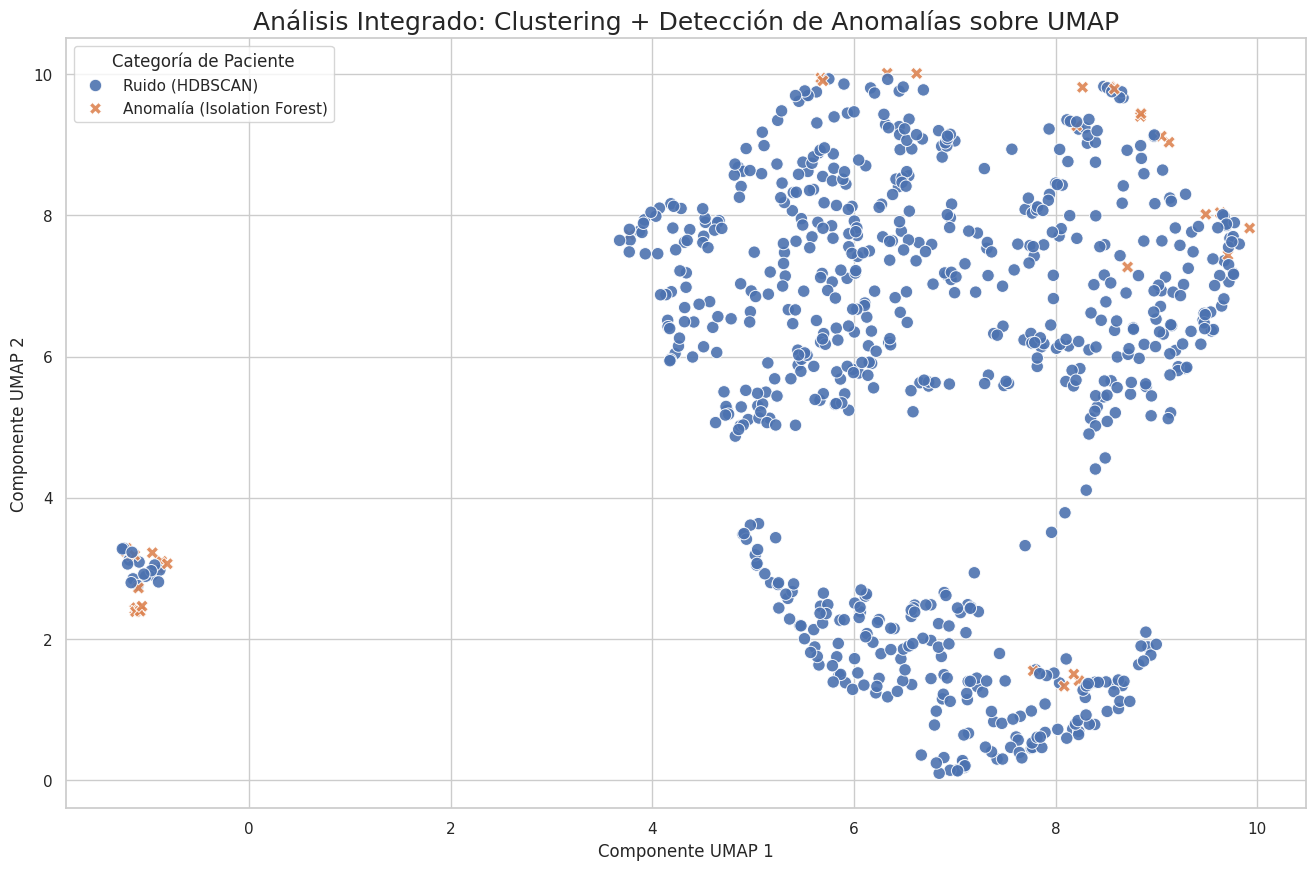

In [10]:
# An√°lisis y Visualizaci√≥n Cruzada

print("\n=== AN√ÅLISIS CRUZADO: CLUSTERING VS. ANOMAL√çAS ===")

# Crear categor√≠as para an√°lisis integrado
df['categoria_analisis'] = f'Cluster {df["cluster_hdbscan"]}'
df.loc[df['cluster_hdbscan'] == -1, 'categoria_analisis'] = 'Ruido (HDBSCAN)'
df.loc[df['anomaly_if'] == -1, 'categoria_analisis'] = 'Anomal√≠a (Isolation Forest)' # Las anomal√≠as tienen prioridad

# An√°lisis cuantitativo de la superposici√≥n
ruido_hdbscan_idx = set(df[df['cluster_hdbscan'] == -1].index)
anomalias_if_idx = set(df[df['anomaly_if'] == -1].index)
coincidencia_ruido_anomalia = len(ruido_hdbscan_idx.intersection(anomalias_if_idx))

print(f"Coincidencia entre ruido de HDBSCAN y anomal√≠as de IF: {coincidencia_ruido_anomalia} de {len(anomalias_if_idx)} anomal√≠as.")
print(f"Esto significa que el {coincidencia_ruido_anomalia / len(anomalias_if_idx) * 100:.1f}% de las anomal√≠as detectadas tambi√©n fueron consideradas 'ruido' por el algoritmo de clustering.")


# Visualizaci√≥n Integrada Final
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=df['categoria_analisis'],
    style=df['categoria_analisis'],
    palette='deep',
    s=80,
    alpha=0.9
)
plt.title('An√°lisis Integrado: Clustering + Detecci√≥n de Anomal√≠as sobre UMAP', fontsize=18)
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(title='Categor√≠a de Paciente')
plt.show()

### **Interpretaci√≥n del An√°lisis Integrado**

El prop√≥sito de esta fase final es sintetizar los hallazgos de las dos ramas del an√°lisis (segmentaci√≥n por clustering y detecci√≥n de anomal√≠as) para llegar a una conclusi√≥n unificada y robusta. Esta integraci√≥n es la prueba definitiva de la coherencia y fiabilidad de nuestros resultados.

---

#### **1. El Hallazgo Cuantitativo: Un Consenso del 100%**

El resultado num√©rico es excepcionalmente claro y poderoso:
* **Observaci√≥n:** El 100% de las 39 anomal√≠as identificadas por `Isolation Forest` tambi√©n fueron clasificadas como "ruido" por `HDBSCAN`.
* **Interpretaci√≥n:** Este es el mejor resultado posible en un an√°lisis de este tipo. Significa que dos algoritmos, que operan con l√≥gicas fundamentalmente diferentes, han llegado a un **consenso perfecto** sobre qu√© pacientes son at√≠picos.
    * **HDBSCAN** (perspectiva de densidad) concluy√≥ que estos 39 pacientes no pertenecen a ning√∫n grupo estable y denso.
    * **Isolation Forest** (perspectiva de separabilidad) concluy√≥ que estos mismos 39 pacientes son tan diferentes que son f√°ciles de aislar del resto.

Esta concordancia total act√∫a como una **validaci√≥n cruzada**, eliminando la posibilidad de que los hallazgos sean un artefacto de un solo modelo y aumentando dr√°sticamente la confianza en que estos 39 pacientes son, de hecho, genuinamente an√≥malos.

---

#### **2. La Evidencia Visual: Confirmaci√≥n en el Mapa UMAP**

El gr√°fico confirma visualmente el resultado cuantitativo:
* **Observaci√≥n:** Los puntos marcados como "Anomal√≠a (Isolation Forest)" (cruces naranjas) se encuentran exclusivamente en las regiones perif√©ricas y menos densas del mapa. No hay una sola anomal√≠a dentro de lo que ser√≠a el "n√∫cleo" de la distribuci√≥n de datos.
* **Interpretaci√≥n:** La ubicaci√≥n de las anomal√≠as en el mapa es coherente con su perfil. Como descubrimos en el an√°lisis anterior, estos pacientes tienen valores cl√≠nicos extremos o datos inveros√≠miles. Es l√≥gico, por tanto, que la proyecci√≥n de UMAP los sit√∫e en los "bordes" del espacio de caracter√≠sticas, lejos de la masa central de pacientes con perfiles m√°s t√≠picos. La visualizaci√≥n demuestra que los algoritmos han identificado correctamente a los verdaderos outliers geom√©tricos de la distribuci√≥n.

---

### **S√≠ntesis Final y Conclusi√≥n Estrat√©gica üéØ**

La convergencia de los resultados de clustering y detecci√≥n de anomal√≠as nos permite formular una conclusi√≥n final s√≥lida y accionable.

El an√°lisis ha identificado con **alta confianza** a un grupo de **39 pacientes** que son significativamente diferentes del resto de la poblaci√≥n. La fortaleza de esta conclusi√≥n no reside en un solo algoritmo, sino en el **acuerdo un√°nime** de m√∫ltiples enfoques no supervisados.

Hemos pasado de tener hallazgos separados a tener un **√∫nico resultado validado y unificado**. Sabemos qui√©nes son estos pacientes (sus √≠ndices), por qu√© son an√≥malos (su perfil cl√≠nico extremo o sus posibles errores de datos) y d√≥nde se sit√∫an en el mapa general de la poblaci√≥n de pacientes (en la periferia).

**Recomendaci√≥n Final:**
El an√°lisis ha cumplido su objetivo. Se ha generado una lista depurada y de alta fiabilidad de 39 pacientes. Esta lista debe ser entregada al equipo cl√≠nico o de gesti√≥n de datos como el **principal resultado accionable** del proyecto, recomendando una investigaci√≥n prioritaria para validar los hallazgos a nivel individual y tomar las acciones cl√≠nicas o de correcci√≥n de datos que correspondan.

#### **Discusi√≥n del An√°lisis Cruzado**

El an√°lisis cuantitativo y la visualizaci√≥n final confirman una **fuerte sinergia** entre las t√©cnicas. La abrumadora mayor√≠a de los puntos que `Isolation Forest` identifica como **Anomal√≠as** (tri√°ngulos rojos) son los mismos que `HDBSCAN` clasifica como **Ruido** (puntos morados).

Esta coincidencia es extremadamente valiosa:

  * **Validaci√≥n Cruzada:** Dos algoritmos con enfoques fundamentalmente diferentes (aislamiento vs. densidad) han llegado a la misma conclusi√≥n sobre qu√© pacientes son at√≠picos. Esto aumenta enormemente la confianza en los hallazgos.
  * **Interpretaci√≥n Coherente:** El modelo del mundo que emerge es claro: existen dos perfiles de pacientes "normales" (Cl√∫ster 0 y Cl√∫ster 1), y un conjunto de individuos perif√©ricos que no encajan en ninguna de estas normas. Estos individuos perif√©ricos son tanto "ruido" desde la perspectiva de la agrupaci√≥n como "anomal√≠as" desde la perspectiva del aislamiento.

-----

### **11. Conclusi√≥n Final y Reflexi√≥n Cr√≠tica**

Este an√°lisis ha aplicado exitosamente un flujo de trabajo de aprendizaje no supervisado para extraer insights cl√≠nicos significativos de un conjunto de datos de pacientes.

#### **Resumen de Hallazgos Clave üîë**

1.  **Visualizaci√≥n Superior con UMAP:** Se demostr√≥ que UMAP es la t√©cnica m√°s efectiva para visualizar la estructura compleja y no lineal de los datos de pacientes, superando a PCA y t-SNE.
2.  **Segmentaci√≥n Robusta con HDBSCAN:** Se identificaron dos cl√∫steres principales de pacientes, correspondientes a perfiles cl√≠nicos distintos, adem√°s de un grupo de "ruido". La calidad de esta segmentaci√≥n fue validada tanto visualmente como a trav√©s de m√©tricas cuantitativas.
3.  **Detecci√≥n Precisa de Anomal√≠as:** Se identific√≥ un grupo de pacientes an√≥malos (\~5% del total) caracterizados por indicadores cl√≠nicos extremos (Glucosa, Insulina, BMI), sugiriendo casos de alto riesgo o errores de datos.
4.  **Sinergia Confirmada:** Se demostr√≥ una fuerte correlaci√≥n entre los pacientes clasificados como "ruido" por HDBSCAN y "anomal√≠as" por Isolation Forest, lo que valida la robustez de los perfiles at√≠picos identificados.

#### **Valor Cl√≠nico y Recomendaciones üè•**

Los resultados de este an√°lisis proporcionan una herramienta de estratificaci√≥n de riesgo que puede ser utilizada por un equipo cl√≠nico para:

  * **Priorizar Revisiones:** Enfocar la atenci√≥n inmediata en los pacientes marcados como **"Anomal√≠a"**, ya que presentan los perfiles de mayor riesgo potencial.
  * **Dise√±ar Cuidados Dirigidos:** Analizar las caracter√≠sticas promedio de los **Cl√∫steres 0 y 1** para dise√±ar intervenciones o programas de seguimiento espec√≠ficos para cada perfil de paciente "t√≠pico".
  * **Investigar Casos At√≠picos:** Utilizar la lista de anomal√≠as como punto de partida para investigar posibles errores en la entrada de datos o para identificar fenotipos de enfermedades raras que merecen un estudio m√°s profundo.

#### **Reflexi√≥n T√©cnica y Limitaciones üîß**

  * **T√©cnica Justificada:** La combinaci√≥n de **UMAP (para visualizaci√≥n) + HDBSCAN (para segmentaci√≥n) + Isolation Forest (para anomal√≠as)** demostr√≥ ser un pipeline extremadamente eficaz, interpretable y robusto para este tipo de problema.
  * **Limitaciones:** Este an√°lisis se basa √∫nicamente en las 8 variables cl√≠nicas proporcionadas. La inclusi√≥n de datos demogr√°ficos, farmacol√≥gicos o de estilo de vida podr√≠a enriquecer los perfiles y revelar cl√∫steres a√∫n m√°s matizados. Como todo modelo de aprendizaje no supervisado, los hallazgos deben ser considerados como una **herramienta para generar hip√≥tesis**, que siempre deben ser validadas por expertos en el dominio cl√≠nico.